# Downloads


In [1]:
!pip install gym

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
from google.colab import widgets
import time

#Deterministic Environment

In [9]:
class DeterministicEnv(gym.Env):
  metadata = {'render.modes':[]}
  def __init__(self):
    self.table_dim = 6
    self.observation_space = spaces.Discrete(self.table_dim*self.table_dim)
    self.action_space = spaces.Discrete(4)
    self.maxtimesteps=15 #change
    self.rewardStates = dict()

    for i in range(self.table_dim):
      for j in range(self.table_dim):
        self.rewardStates[(i,j)] = -0.05

    t=0.1
    for j in range(self.table_dim):
      self.rewardStates[(0,j)] = t
      t+=0.1
    for i in range(1,self.table_dim):
      self.rewardStates[(i,self.table_dim-1)] = t
      t+=0.05

    self.rewardStates[(self.table_dim-1,self.table_dim-1)] = 10

    # Print reward map
    print(self.rewardStates)
    for i in range(6):
      print("")
      for j in range(6):
        print(str(self.rewardStates[(i,j)]),end=" ")


  def reset(self):
    self.timesteps = 0
    self.agent_pos = [0,0]
    self.goal_pos = [self.table_dim-1,self.table_dim-1]
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    return self.agent_pos



  def step(self,action):
    self.state = np.random.choice(self.observation_space.n)

    if action == 0: #down
      self.agent_pos[0] +=1
    elif action==1: #up
      self.agent_pos[0] -=1
    elif action==2:#right
      self.agent_pos[1] += 1
    elif action==3: #left
      self.agent_pos[1] -= 1
    
    self.agent_pos = np.clip(self.agent_pos,0,self.table_dim-1)
    self.state = np.zeros((self.table_dim,self.table_dim))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[2,2] = 0.3
    self.state[1,4] = 0.3
    observation = self.state.flatten()
    reward = 0
    if tuple(self.agent_pos) in self.rewardStates: #Checking if agent is in reward position
      reward = self.rewardStates[tuple(self.agent_pos)]

    self.timesteps +=1
    done = False
    if (self.timesteps >= self.maxtimesteps) or (tuple(self.agent_pos) == tuple(self.goal_pos)):#Ensuring Safety in AI
      done = True 
    info = {}

    return self.agent_pos, reward, done, info



  def render(self):
    plt.imshow(self.state)

In [ ]:
DeterministicEnv()

{(0, 0): 0.1, (0, 1): 0.2, (0, 2): 0.30000000000000004, (0, 3): 0.4, (0, 4): 0.5, (0, 5): 0.6, (1, 0): -0.05, (1, 1): -0.05, (1, 2): -0.05, (1, 3): -0.05, (1, 4): -0.05, (1, 5): 0.7, (2, 0): -0.05, (2, 1): -0.05, (2, 2): -0.05, (2, 3): -0.05, (2, 4): -0.05, (2, 5): 0.75, (3, 0): -0.05, (3, 1): -0.05, (3, 2): -0.05, (3, 3): -0.05, (3, 4): -0.05, (3, 5): 0.8, (4, 0): -0.05, (4, 1): -0.05, (4, 2): -0.05, (4, 3): -0.05, (4, 4): -0.05, (4, 5): 0.8500000000000001, (5, 0): -0.05, (5, 1): -0.05, (5, 2): -0.05, (5, 3): -0.05, (5, 4): -0.05, (5, 5): 1}

0.1 0.2 0.30000000000000004 0.4 0.5 0.6 
-0.05 -0.05 -0.05 -0.05 -0.05 0.7 
-0.05 -0.05 -0.05 -0.05 -0.05 0.75 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8500000000000001 
-0.05 -0.05 -0.05 -0.05 -0.05 1 

# ACNetwork

In [9]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
class ACNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(ACNetwork, self).__init__()
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions

    self.fc1 = nn.Linear(input_dims,self.fc1_dims)
    # self.fc1.weight.data.normal_(0, 0.1)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
    # self.fc2.weight.data.normal_(0, 0.1)
    self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
    # self.fc3.weight.data.normal_(0, 0.1)
    
    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):

      state = T.Tensor(state).to(self.device)
      layer1 = F.relu(self.fc1(state))
      layer2 = F.relu(self.fc2(layer1))
      actions = self.fc3(layer2)

      return actions

# AC Agent

In [39]:
class ACAgent:
    # def __init__(self, env,epsilon=1.0,lr=0.6,gamma=0.9):
    def __init__(self,env, alpha, beta, input_dims, gamma=0.99,
                 fc1_dims=256, fc2_dims=256, n_actions=2):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
       
        self.alpha = alpha
        self.beta = beta

        self.gamma = gamma

        self.actor = ACNetwork(alpha, input_dims, fc1_dims,fc2_dims, n_actions=n_actions)
        self.critic = ACNetwork(beta, input_dims, fc1_dims,fc2_dims, n_actions=1)
        
        self.log_p = None

    def step(self,observation):
      
      probabilities = F.softmax(self.actor.forward(observation))
      action_p = T.distributions.Categorical(probabilities)
      action = action_p.sample()
      self.log_p = action_p.log_prob(action)

      return action.item()
    

    def learn(self, state, reward, next_state, done):
          #New Code Starts
      self.actor.optimizer.zero_grad()
      self.critic.optimizer.zero_grad()

      new_critic_value = 0
      if not done:
        new_critic_value = self.critic.forward(next_state)
      critic_value = self.critic.forward(state)
      reward = T.tensor(reward, dtype=T.float).to(self.actor.device)

      delta = reward + self.gamma*new_critic_value - critic_value
      
      critic_loss = delta**2
      actor_loss = -self.log_p * delta
      

      (actor_loss + critic_loss).backward()

      self.actor.optimizer.step()
      self.critic.optimizer.step()
        #New Code ends


# Hyperparameter_1
alpha=0.0001, beta=0.005, input_dims=2, gamma=0.9,fc1_dims=16, fc2_dims=32, n_actions=4

{(0, 0): 0.1, (0, 1): 0.2, (0, 2): 0.30000000000000004, (0, 3): 0.4, (0, 4): 0.5, (0, 5): 0.6, (1, 0): -0.05, (1, 1): -0.05, (1, 2): -0.05, (1, 3): -0.05, (1, 4): -0.05, (1, 5): 0.7, (2, 0): -0.05, (2, 1): -0.05, (2, 2): -0.05, (2, 3): -0.05, (2, 4): -0.05, (2, 5): 0.75, (3, 0): -0.05, (3, 1): -0.05, (3, 2): -0.05, (3, 3): -0.05, (3, 4): -0.05, (3, 5): 0.8, (4, 0): -0.05, (4, 1): -0.05, (4, 2): -0.05, (4, 3): -0.05, (4, 4): -0.05, (4, 5): 0.8500000000000001, (5, 0): -0.05, (5, 1): -0.05, (5, 2): -0.05, (5, 3): -0.05, (5, 4): -0.05, (5, 5): 10}

0.1 0.2 0.30000000000000004 0.4 0.5 0.6 
-0.05 -0.05 -0.05 -0.05 -0.05 0.7 
-0.05 -0.05 -0.05 -0.05 -0.05 0.75 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8500000000000001 
-0.05 -0.05 -0.05 -0.05 -0.05 10 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


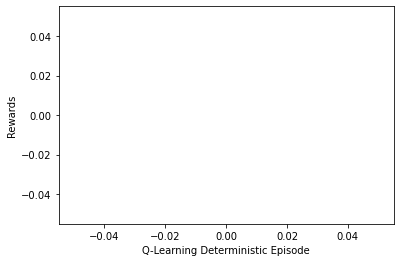

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


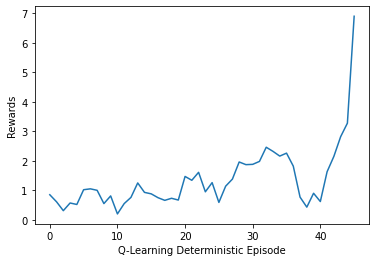

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


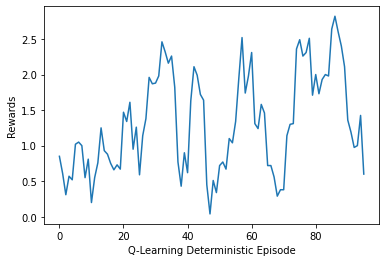

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


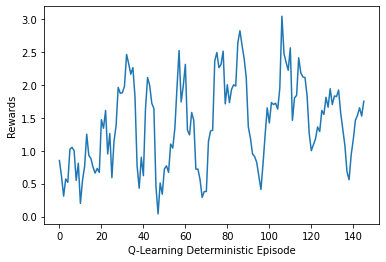

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


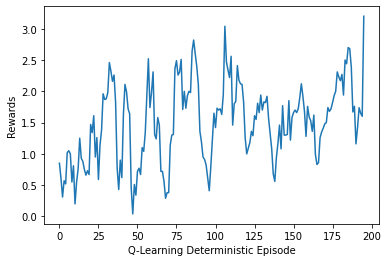

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


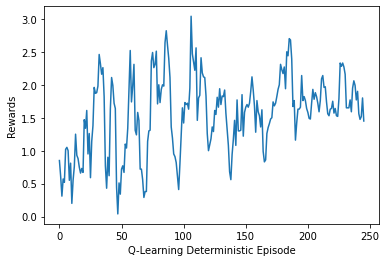

251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


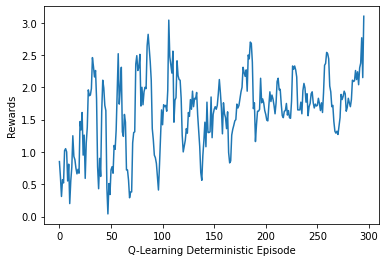

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350


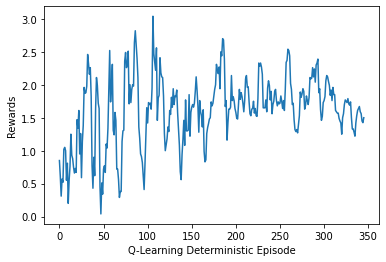

351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


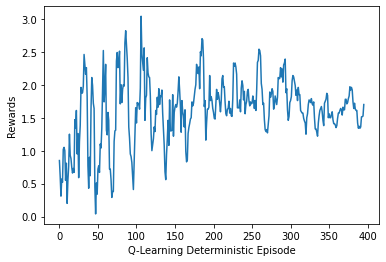

401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450


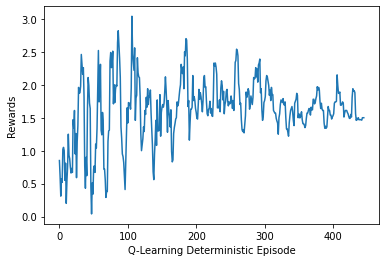

451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


In [23]:
# setting up environment and agent
env = DeterministicEnv()

agent = ACAgent(env=env,alpha=0.0001, beta=0.005, input_dims=2, gamma=0.9,fc1_dims=16, fc2_dims=32, n_actions=4)

episodes = 500
q_d_rewards_1 = []

for episode in range(episodes):
  print(episode)
  obs = env.reset()
  done = False


  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)
    curr_reward+=reward
    next_state = np.copy(obs)

    agent.learn(state,reward,next_state,done)

  
  q_d_rewards_1.append(curr_reward)

  if not episode%50:
    window = 5
    plt.xlabel('AC Deterministic Episode')
    plt.ylabel('Rewards')
    plt.plot([np.mean(q_d_rewards_1[tr:tr+window]) for tr in range(window, len(q_d_rewards_1))])
    plt.show()


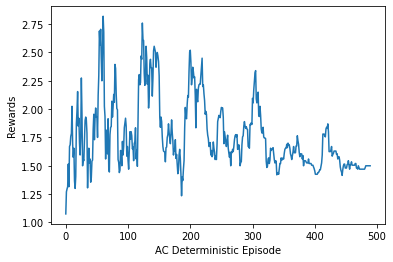

In [58]:
window = 10
plt.xlabel('AC Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards_1[tr:tr+window]) for tr in range(window, len(q_d_rewards_1))])

# Hyperparameter_2
agent = ACAgent(env=env,alpha=0.001, beta=0.05, input_dims=2, gamma=0.95,fc1_dims=8, fc2_dims=16, n_actions=4)

{(0, 0): 0.1, (0, 1): 0.2, (0, 2): 0.30000000000000004, (0, 3): 0.4, (0, 4): 0.5, (0, 5): 0.6, (1, 0): -0.05, (1, 1): -0.05, (1, 2): -0.05, (1, 3): -0.05, (1, 4): -0.05, (1, 5): 0.7, (2, 0): -0.05, (2, 1): -0.05, (2, 2): -0.05, (2, 3): -0.05, (2, 4): -0.05, (2, 5): 0.75, (3, 0): -0.05, (3, 1): -0.05, (3, 2): -0.05, (3, 3): -0.05, (3, 4): -0.05, (3, 5): 0.8, (4, 0): -0.05, (4, 1): -0.05, (4, 2): -0.05, (4, 3): -0.05, (4, 4): -0.05, (4, 5): 0.8500000000000001, (5, 0): -0.05, (5, 1): -0.05, (5, 2): -0.05, (5, 3): -0.05, (5, 4): -0.05, (5, 5): 10}

0.1 0.2 0.30000000000000004 0.4 0.5 0.6 
-0.05 -0.05 -0.05 -0.05 -0.05 0.7 
-0.05 -0.05 -0.05 -0.05 -0.05 0.75 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8500000000000001 
-0.05 -0.05 -0.05 -0.05 -0.05 10 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


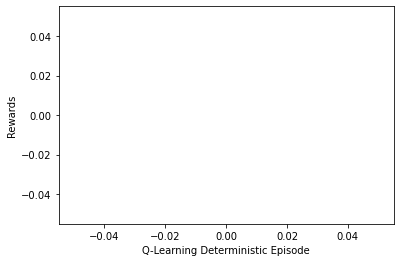

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


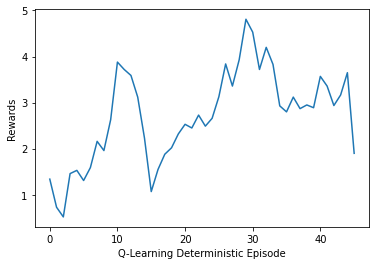

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


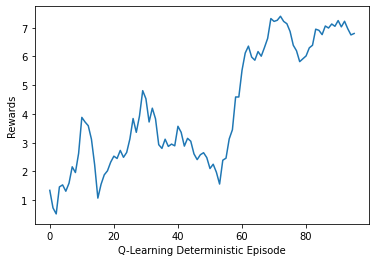

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


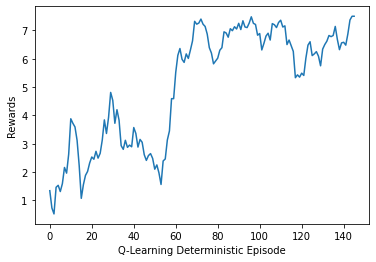

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


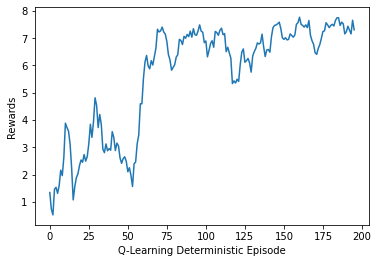

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


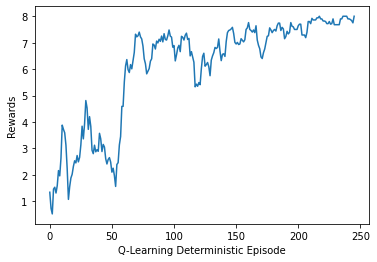

251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


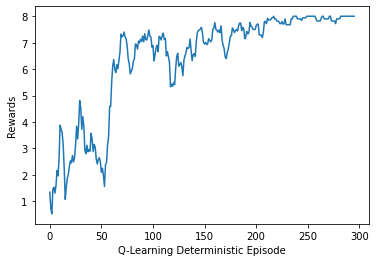

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350


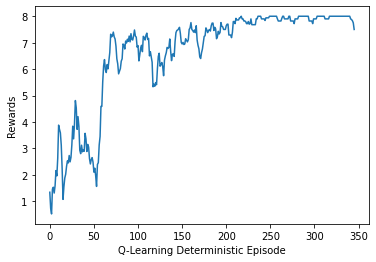

351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


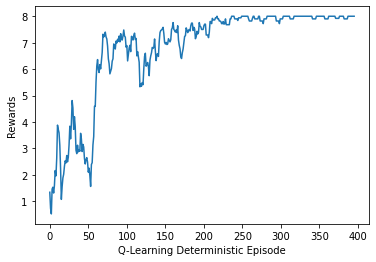

401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450


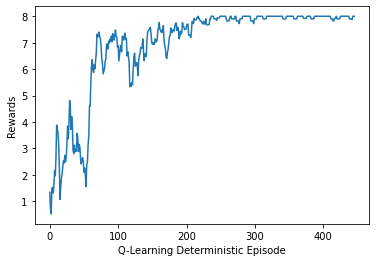

451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


In [42]:
# setting up environment and agent
env = DeterministicEnv()

agent = ACAgent(env=env,alpha=0.001, beta=0.05, input_dims=2, gamma=0.95,fc1_dims=8, fc2_dims=16, n_actions=4)

episodes = 500
q_d_rewards_2 = []

for episode in range(episodes):
  print(episode)
  obs = env.reset()
  done = False


  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)
    curr_reward+=reward
    next_state = np.copy(obs)

    agent.learn(state,reward,next_state,done)

  
  q_d_rewards_2.append(curr_reward)

  if not episode%50:
    window = 5
    plt.xlabel('AC Deterministic Episode')
    plt.ylabel('Rewards')
    plt.plot([np.mean(q_d_rewards_2[tr:tr+window]) for tr in range(window, len(q_d_rewards_2))])
    plt.show()


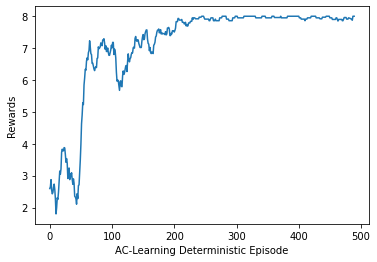

In [57]:
window = 10
plt.xlabel('AC-Learning Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards_2[tr:tr+window]) for tr in range(window, len(q_d_rewards_2))])

# Hyperparameter_3
agent = ACAgent(env=env,alpha=0.01, beta=0.5, input_dims=2, gamma=0.95,fc1_dims=8, fc2_dims=16, n_actions=4)


{(0, 0): 0.1, (0, 1): 0.2, (0, 2): 0.30000000000000004, (0, 3): 0.4, (0, 4): 0.5, (0, 5): 0.6, (1, 0): -0.05, (1, 1): -0.05, (1, 2): -0.05, (1, 3): -0.05, (1, 4): -0.05, (1, 5): 0.7, (2, 0): -0.05, (2, 1): -0.05, (2, 2): -0.05, (2, 3): -0.05, (2, 4): -0.05, (2, 5): 0.75, (3, 0): -0.05, (3, 1): -0.05, (3, 2): -0.05, (3, 3): -0.05, (3, 4): -0.05, (3, 5): 0.8, (4, 0): -0.05, (4, 1): -0.05, (4, 2): -0.05, (4, 3): -0.05, (4, 4): -0.05, (4, 5): 0.8500000000000001, (5, 0): -0.05, (5, 1): -0.05, (5, 2): -0.05, (5, 3): -0.05, (5, 4): -0.05, (5, 5): 10}

0.1 0.2 0.30000000000000004 0.4 0.5 0.6 
-0.05 -0.05 -0.05 -0.05 -0.05 0.7 
-0.05 -0.05 -0.05 -0.05 -0.05 0.75 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8 
-0.05 -0.05 -0.05 -0.05 -0.05 0.8500000000000001 
-0.05 -0.05 -0.05 -0.05 -0.05 10 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


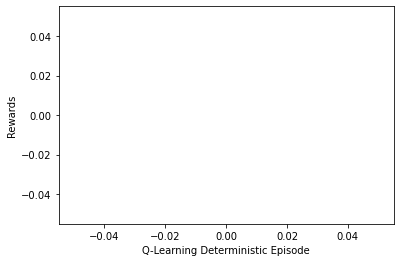

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


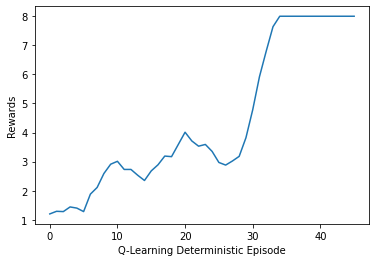

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


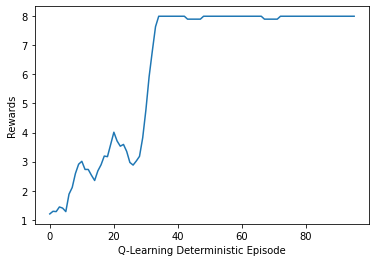

101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


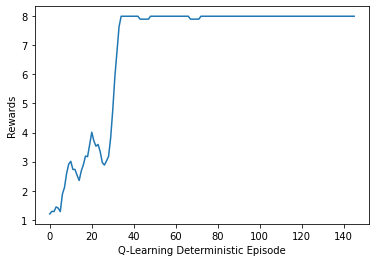

151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


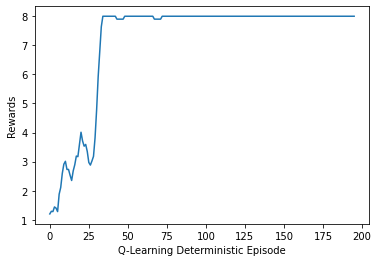

201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


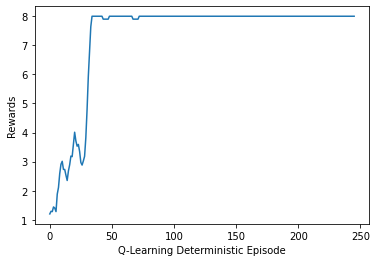

251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300


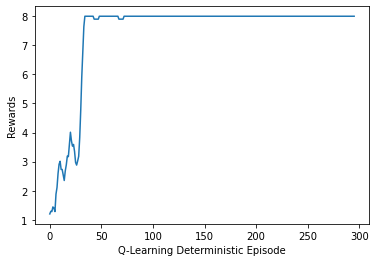

301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350


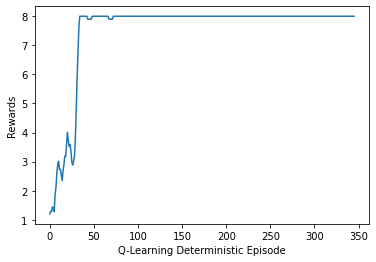

351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


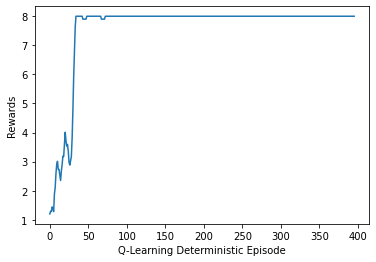

401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450


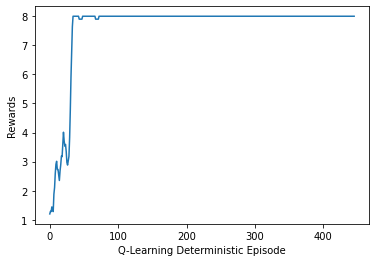

451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


In [46]:
# setting up environment and agent
env = DeterministicEnv()

agent = ACAgent(env=env,alpha=0.01, beta=0.5, input_dims=2, gamma=0.95,fc1_dims=8, fc2_dims=16, n_actions=4)

episodes = 500
q_d_rewards_3 = []

for episode in range(episodes):
  print(episode)
  obs = env.reset()
  done = False


  curr_reward = 0

  while not done:
    action = agent.step(obs)
    state = np.copy(obs)
    obs, reward, done, info = env.step(action)
    curr_reward+=reward
    next_state = np.copy(obs)

    agent.learn(state,reward,next_state,done)

  
  q_d_rewards_3.append(curr_reward)

  if not episode%50:
    window = 5
    plt.xlabel('AC Deterministic Episode')
    plt.ylabel('Rewards')
    plt.plot([np.mean(q_d_rewards_3[tr:tr+window]) for tr in range(window, len(q_d_rewards_3))])
    plt.show()


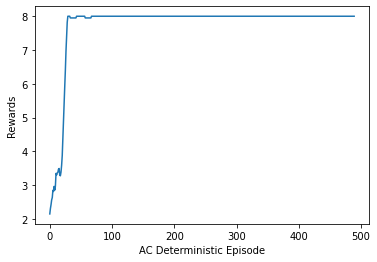

In [56]:
window = 10
plt.xlabel('AC Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards_3[tr:tr+window]) for tr in range(window, len(q_d_rewards_3))])

# Final

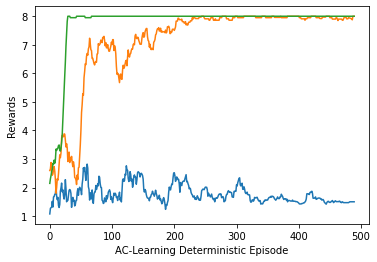

In [55]:
window = 10
plt.xlabel('AC-Learning Deterministic Episode')
plt.ylabel('Rewards')
plt.plot([np.mean(q_d_rewards_1[tr:tr+window]) for tr in range(window, len(q_d_rewards_1))])
plt.plot([np.mean(q_d_rewards_2[tr:tr+window]) for tr in range(window, len(q_d_rewards_2))])
plt.plot([np.mean(q_d_rewards_3[tr:tr+window]) for tr in range(window, len(q_d_rewards_3))])
